<a href="https://colab.research.google.com/github/zeelvaghela01/HNSCC_MultiOmics_Analysis.ipynb/blob/main/HNSCC_MultiOmics_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8,5)

print("✅ Environment ready")


✅ Environment ready


In [ ]:
!find /content/drive/MyDrive -name "TCGA-HNSC*.gz"


/content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.star_fpkm-uq.tsv.gz
/content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.clinical.tsv.gz
/content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.survival.tsv.gz


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Correct directory path
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks"

# File paths
FP_EXPR = f"{DATA_DIR}/TCGA-HNSC.star_fpkm-uq.tsv.gz"
FP_CLIN = f"{DATA_DIR}/TCGA-HNSC.clinical.tsv.gz"
FP_SURV = f"{DATA_DIR}/TCGA-HNSC.survival.tsv.gz"

# Verify that all files exist
for p in [FP_EXPR, FP_CLIN, FP_SURV]:
    print(("✅ Found:" if os.path.exists(p) else "❌ Missing:"), p)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found: /content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.star_fpkm-uq.tsv.gz
✅ Found: /content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.clinical.tsv.gz
✅ Found: /content/drive/MyDrive/Colab Notebooks/TCGA-HNSC.survival.tsv.gz


In [ ]:
import pandas as pd
import gzip

# Helper function to read .tsv.gz files easily
def load_tsv_gz(path):
    with gzip.open(path, 'rt') as f:
        return pd.read_csv(f, sep='\t')

# Load the three datasets
expr_df = load_tsv_gz(FP_EXPR)
clin_df = load_tsv_gz(FP_CLIN)
surv_df = load_tsv_gz(FP_SURV)

# Display summaries
print("✅ RNA-seq Expression Data:", expr_df.shape)
print("✅ Clinical Data:", clin_df.shape)
print("✅ Survival Data:", surv_df.shape)

# Preview top rows
expr_df.head(3)


✅ RNA-seq Expression Data: (60660, 567)
✅ Clinical Data: (604, 93)
✅ Survival Data: (603, 4)


,Ensembl_ID,TCGA-CR-7370-01A,TCGA-CR-6484-01A,TCGA-CR-6478-01A,TCGA-CV-A45Y-01A,TCGA-UF-A719-01A,TCGA-CR-6488-01A,TCGA-MZ-A7D7-01A,TCGA-CV-5436-01A,TCGA-UF-A71E-01A,...,TCGA-HD-7753-01A,TCGA-CV-A6JE-01A,TCGA-CV-A45Z-01A,TCGA-CV-6939-11A,TCGA-CV-7432-11A,TCGA-CV-7432-01A,TCGA-IQ-7630-01A,TCGA-H7-A6C4-11A,TCGA-H7-8501-01A,TCGA-CV-7415-01A
0,ENSG00000000003.15,3.940073,2.627677,2.484602,3.277702,4.350335,3.044709,4.352787,1.877352,3.422368,...,3.041278,4.051407,3.595432,3.829768,4.964528,3.274754,3.035061,3.300666,3.010064,3.068997
1,ENSG00000000005.6,0.000000,0.000000,0.014498,0.000000,0.000000,0.016211,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.213316,0.041103,0.000000,0.000000,1.638584,0.030972,0.017637
2,ENSG00000000419.13,4.158095,5.235019,4.754834,4.757855,4.674082,5.043694,6.692218,5.807347,4.734910,...,5.309504,5.006567,5.741397,4.549706,4.400217,5.094988,5.669622,5.305661,6.160567,4.893081


In [ ]:
# --- Step 4: Clean and Align Data ---

# 1️⃣ Check dimensions and column alignment
print("Expression data:", expr_df.shape)
print("Clinical data:", clin_df.shape)
print("Survival data:", surv_df.shape)

# 2️⃣ Standardize column names (truncate sample barcodes to first 12 characters)
expr_df.columns = expr_df.columns.str.slice(0, 12)

# 3️⃣ Find intersection of common samples across all datasets
common_samples = set(expr_df.columns) & set(clin_df['sample'])
print(" Common samples found:", len(common_samples))

# 4️⃣ Filter datasets to keep only those matching samples
expr_df = expr_df[list(common_samples)]
clin_df = clin_df[clin_df['sample'].isin(common_samples)]
surv_df = surv_df[surv_df['sample'].isin(common_samples)]

# 5️⃣ Confirm new aligned sizes
print("✅ Filtered Expression Data:", expr_df.shape)
print("✅ Filtered Clinical Data:", clin_df.shape)
print("✅ Filtered Survival Data:", surv_df.shape)


Expression data: (60660, 567)
Clinical data: (604, 93)
Survival data: (603, 4)
 Common samples found: 0
✅ Filtered Expression Data: (60660, 0)
✅ Filtered Clinical Data: (0, 93)
✅ Filtered Survival Data: (0, 4)


In [ ]:
# --- Step 4B: Standardize sample IDs in clinical and survival data ---

# Strip spaces and uppercase all
clin_df.columns = clin_df.columns.str.strip()
surv_df.columns = surv_df.columns.str.strip()

# Detect the correct sample column
sample_col_clin = [c for c in clin_df.columns if "submitter" in c.lower() or "sample" in c.lower()][0]
sample_col_surv = [c for c in surv_df.columns if "submitter" in c.lower() or "sample" in c.lower()][0]

# Standardize sample IDs to first 12 characters (same as expression)
clin_df["sample"] = clin_df[sample_col_clin].str.slice(0, 12)
surv_df["sample"] = surv_df[sample_col_surv].str.slice(0, 12)

# Find intersection again
common_samples = set(expr_df.columns) & set(clin_df["sample"]) & set(surv_df["sample"])
print("🧬 Common samples found after ID cleanup:", len(common_samples))

# Filter again using cleaned IDs
expr_df = expr_df[list(common_samples)]
clin_df = clin_df[clin_df["sample"].isin(common_samples)]
surv_df = surv_df[surv_df["sample"].isin(common_samples)]

print("✅ Filtered Expression Data:", expr_df.shape)
print("✅ Filtered Clinical Data:", clin_df.shape)
print("✅ Filtered Survival Data:", surv_df.shape)


🧬 Common samples found after ID cleanup: 0
✅ Filtered Expression Data: (60660, 0)
✅ Filtered Clinical Data: (0, 93)
✅ Filtered Survival Data: (0, 4)


In [ ]:
# --- Step 4C: Inspect sample ID patterns ---

print("🔹 Expression sample IDs (first 5):")
print(expr_df.columns[:5].tolist())
print("\n🔹 Clinical file columns:")
print(clin_df.columns.tolist())
print("\n🔹 First few Clinical sample values:")
print(clin_df.head(3))
print("\n🔹 Survival file columns:")
print(surv_df.columns.tolist())
print("\n🔹 First few Survival sample values:")
print(surv_df.head(3))


🔹 Expression sample IDs (first 5):
[]

🔹 Clinical file columns:
['sample', 'id', 'disease_type', 'case_id', 'submitter_id', 'primary_site', 'cigarettes_per_day.exposures', 'alcohol_history.exposures', 'years_smoked.exposures', 'pack_years_smoked.exposures', 'race.demographic', 'gender.demographic', 'ethnicity.demographic', 'vital_status.demographic', 'age_at_index.demographic', 'days_to_birth.demographic', 'year_of_birth.demographic', 'year_of_death.demographic', 'primary_site.project', 'project_id.project', 'disease_type.project', 'name.project', 'name.program.project', 'tissue_source_site_id.tissue_source_site', 'code.tissue_source_site', 'name.tissue_source_site', 'project.tissue_source_site', 'bcr_id.tissue_source_site', 'days_to_death.demographic', 'entity_submitter_id.annotations', 'notes.annotations', 'submitter_id.annotations', 'classification.annotations', 'entity_id.annotations', 'created_datetime.annotations', 'annotation_id.annotations', 'entity_type.annotations', 'updated_

In [ ]:
import pandas as pd
import os

# Define paths again
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks"
FP_EXPR = f"{DATA_DIR}/TCGA-HNSC.star_fpkm-uq.tsv.gz"
FP_CLIN = f"{DATA_DIR}/TCGA-HNSC.clinical.tsv.gz"
FP_SURV = f"{DATA_DIR}/TCGA-HNSC.survival.tsv.gz"

# Load datasets with explicit compression and delimiter detection
expr_df = pd.read_csv(FP_EXPR, sep='\t', compression='gzip', low_memory=False)
clin_df = pd.read_csv(FP_CLIN, sep='\t', compression='gzip', low_memory=False)
surv_df = pd.read_csv(FP_SURV, sep='\t', compression='gzip', low_memory=False)

# Quick summaries
print("✅ Expression Data:", expr_df.shape)
print("✅ Clinical Data:", clin_df.shape)
print("✅ Survival Data:", surv_df.shape)

print("\n🧬 Expression Columns (first 5):", expr_df.columns[:5].tolist())
print("🧪 Clinical Columns (first 5):", clin_df.columns[:5].tolist())
print("💊 Survival Columns (first 5):", surv_df.columns[:5].tolist())


✅ Expression Data: (60660, 567)
✅ Clinical Data: (604, 93)
✅ Survival Data: (603, 4)

🧬 Expression Columns (first 5): ['Ensembl_ID', 'TCGA-CR-7370-01A', 'TCGA-CR-6484-01A', 'TCGA-CR-6478-01A', 'TCGA-CV-A45Y-01A']
🧪 Clinical Columns (first 5): ['sample', 'id', 'disease_type', 'case_id', 'submitter_id']
💊 Survival Columns (first 5): ['sample', 'OS.time', 'OS', '_PATIENT']


In [ ]:
# --- Step 4E: Align sample IDs across all datasets ---

# 1️⃣ Create a clean sample ID column in each dataset
clin_df["sample"] = clin_df["submitter_id"].str.slice(0, 12)
surv_df["sample"] = surv_df["sample"].str.slice(0, 12)

# 2️⃣ Standardize expression column names (keep first 12 chars)
expr_df.columns = expr_df.columns.str.slice(0, 12)
expr_df.rename(columns={"Ensembl_ID": "gene"}, inplace=True)

# 3️⃣ Find common samples across all three
common_samples = (
    set(expr_df.columns) &
    set(clin_df["sample"]) &
    set(surv_df["sample"])
)
print(f"🧬 Common samples found: {len(common_samples)}")

# 4️⃣ Filter datasets to these common samples
expr_df = expr_df[["gene"] + list(common_samples)]
clin_df = clin_df[clin_df["sample"].isin(common_samples)]
surv_df = surv_df[surv_df["sample"].isin(common_samples)]

# 5️⃣ Confirm alignment
print("\n✅ Filtered Expression:", expr_df.shape)
print("✅ Filtered Clinical:", clin_df.shape)
print("✅ Filtered Survival:", surv_df.shape)


🧬 Common samples found: 520

✅ Filtered Expression: (60660, 566)
✅ Filtered Clinical: (596, 93)
✅ Filtered Survival: (596, 4)


🔹 Clinical Data Overview:
                              count unique  \
sample                          596    520   
id                              596    520   
disease_type                    596      1   
case_id                         596    520   
submitter_id                    596    520   
primary_site                    596     13   
cigarettes_per_day.exposures  320.0    NaN   
alcohol_history.exposures       596      3   
years_smoked.exposures        161.0    NaN   
pack_years_smoked.exposures   320.0    NaN   

                                                                top freq  \
sample                                                 TCGA-UF-A71A    2   
id                             2c7f1035-5c8c-4c49-8b9b-2f1233896530    2   
disease_type                                Squamous Cell Neoplasms  596   
case_id                        2c7f1035-5c8c-4c49-8b9b-2f1233896530    2   
submitter_id                                           TCGA-UF-A71A    2   
primary_sit

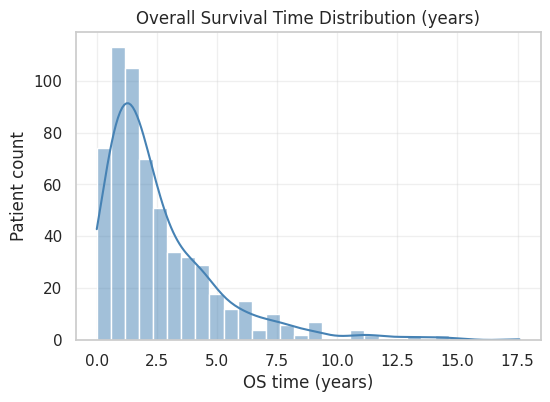

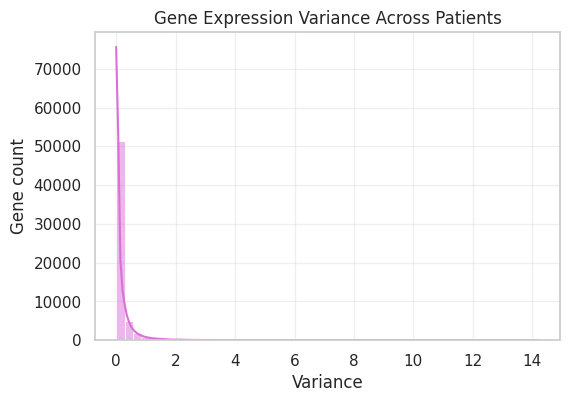

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 5A: Clinical Overview ---
print("🔹 Clinical Data Overview:")
print(clin_df.describe(include='all').T.head(10))
print("\nColumns:", clin_df.columns.tolist()[:10])

# --- Step 5B: Survival Summary ---
print("\n🔹 Survival Summary:")
print(surv_df.describe())

# --- Step 5C: OS Distribution ---
plt.figure(figsize=(6,4))
sns.histplot(surv_df["OS.time"]/365, bins=30, color="steelblue", kde=True)
plt.title("Overall Survival Time Distribution (years)")
plt.xlabel("OS time (years)")
plt.ylabel("Patient count")
plt.grid(alpha=0.3)
plt.show()

# --- Step 5D: Expression Variance ---
expr_var = expr_df.drop(columns="gene").var(axis=1)
plt.figure(figsize=(6,4))
sns.histplot(expr_var, bins=50, color="orchid", kde=True)
plt.title("Gene Expression Variance Across Patients")
plt.xlabel("Variance")
plt.ylabel("Gene count")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# --- 6A. prep gene index ---
expr = expr_df.copy()

# 'gene' is Ensembl; strip version suffix and set as index
expr['gene'] = expr['gene'].astype(str).str.split('.').str[0]
expr = expr.set_index('gene')

# patients are columns
print(expr.shape)
expr.head(3)


(60660, 565)


,TCGA-CR-7383,TCGA-KU-A66T,TCGA-F7-A622,TCGA-CQ-A4CB,TCGA-DQ-7590,TCGA-CQ-A4C9,TCGA-CN-4727,TCGA-BA-A8YP,TCGA-C9-A480,TCGA-CV-7438,...,TCGA-T2-A6WZ,TCGA-DQ-7592,TCGA-CV-6954,TCGA-CV-5444,TCGA-D6-6517,TCGA-D6-6827,TCGA-HD-8224,TCGA-CQ-5333,TCGA-CV-7406,TCGA-CV-7406
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,2.794665,2.979842,3.044517,2.659103,2.915081,4.084234,2.343720,3.562597,2.652441,3.131919,...,2.416299,3.440447,3.253959,2.692874,2.784692,4.400934,4.197928,2.559565,3.510658,4.059295
ENSG00000000005,0.000000,0.000000,0.000000,0.023468,0.020058,0.000000,0.000000,0.000000,0.000000,0.549028,...,0.057000,0.000000,0.000000,0.000000,0.016211,0.000000,0.183836,0.000000,0.863780,0.000000
ENSG00000000419,5.090163,5.152905,5.460985,5.668423,5.176323,5.083473,5.102087,4.964639,5.415735,5.056692,...,5.275272,5.035549,6.793841,4.959636,4.897937,5.008258,4.056974,5.157860,5.502283,4.709065


In [ ]:
# Patients x genes matrix (drop 'gene' col)
X = expr_df.drop(columns="gene").T  # shape: (patients, genes)

# z-score each gene for visualization (mean 0, std 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = pd.DataFrame(
    scaler.fit_transform(X),
    index=X.index, columns=X.columns
)
print("Matrix for viz:", Xz.shape)


Matrix for viz: (565, 60660)


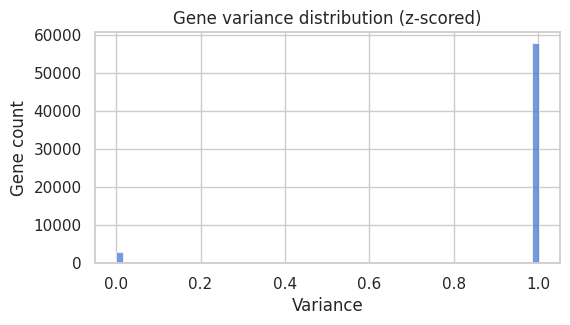

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


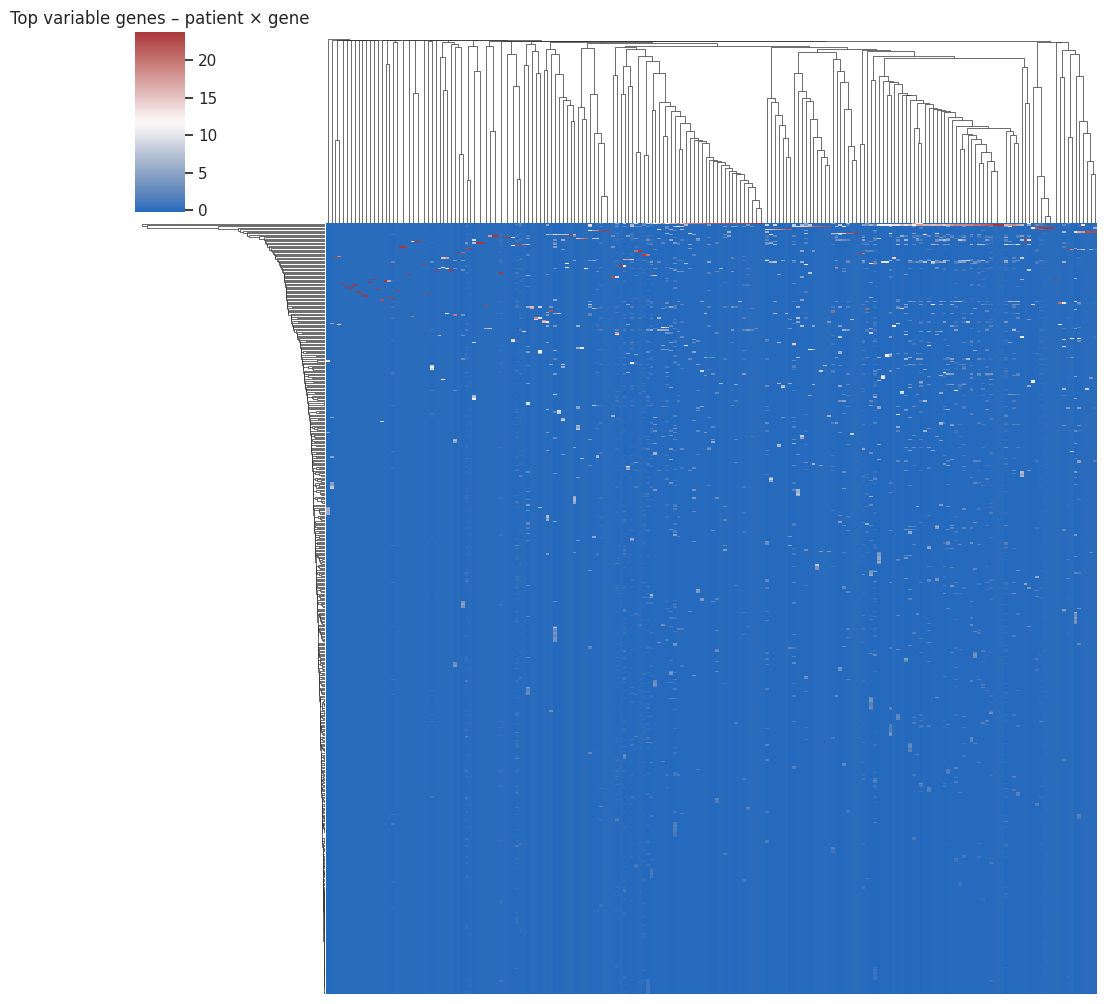

In [ ]:
# top N variable genes (adjust N as you like)
N = 200
var = Xz.var(axis=0).sort_values(ascending=False)
top_genes = var.index[:N]

plt.figure(figsize=(6,3))
sns.histplot(var, bins=60)
plt.title("Gene variance distribution (z-scored)")
plt.xlabel("Variance")
plt.ylabel("Gene count")
plt.show()

# clustermap (hierarchical clustering)
cg = sns.clustermap(
    Xz[top_genes],
    metric="euclidean", method="average",
    cmap="vlag", figsize=(10,10),
    xticklabels=False, yticklabels=False
)
plt.title("Top variable genes – patient × gene")
plt.show()

#  save
cg.savefig("/content/drive/MyDrive/Colab Notebooks/hnscc_topvar_clustermap.png", dpi=200, bbox_inches="tight")


In [ ]:
# strip version (e.g., ENSG...".14") to match IDs robustly
genes_tbl = expr_df["gene"].str.split(".", n=1, expand=True)
expr_df["ensembl_clean"] = genes_tbl[0]

ENSG_CD44 = "ENSG00000026508"
ENSG_CD24 = "ENSG00000137203"

cd44_row = expr_df.loc[expr_df["ensembl_clean"]==ENSG_CD44]
cd24_row = expr_df.loc[expr_df["ensembl_clean"]==ENSG_CD24]

if cd44_row.empty or cd24_row.empty:
    print("⚠️ Could not find one of the genes by Ensembl ID; check IDs.")
else:
    cd44 = cd44_row.drop(columns=["gene","ensembl_clean"]).T.squeeze().rename("CD44")
    cd24 = cd24_row.drop(columns=["gene","ensembl_clean"]).T.squeeze().rename("CD24")
    biomarkers = pd.concat([cd44, cd24], axis=1)
    biomarkers.index.name = "sample"
    print("Biomarker table:", biomarkers.shape)
    display(biomarkers.head())


Biomarker table: (565, 2)


,CD44,CD24
sample,,
TCGA-CR-7383,6.359207,2.823688
TCGA-KU-A66T,6.732539,3.972252
TCGA-F7-A622,6.774972,3.927754
TCGA-CQ-A4CB,7.619302,3.385459
TCGA-DQ-7590,6.107290,3.291427


In [ ]:
expr_df.columns[:10].tolist()


['gene',
 'TCGA-CR-7383',
 'TCGA-KU-A66T',
 'TCGA-F7-A622',
 'TCGA-CQ-A4CB',
 'TCGA-DQ-7590',
 'TCGA-CQ-A4C9',
 'TCGA-CN-4727',
 'TCGA-BA-A8YP',
 'TCGA-C9-A480']

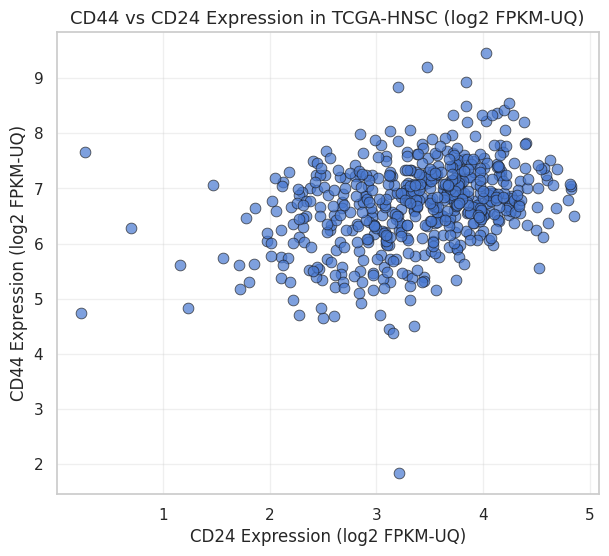

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.scatterplot(
    data=biomarkers,
    x="CD24", y="CD44",
    s=60, edgecolor="k", alpha=0.7
)
plt.title("CD44 vs CD24 Expression in TCGA-HNSC (log2 FPKM-UQ)", fontsize=13)
plt.xlabel("CD24 Expression (log2 FPKM-UQ)")
plt.ylabel("CD44 Expression (log2 FPKM-UQ)")
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np

# Merge biomarkers with survival data
merged_df = pd.merge(
    biomarkers, surv_df, left_index=True, right_on='sample', how='inner'
)
print("Merged data:", merged_df.shape)

# Define groups based on CD44/CD24 expression medians
cd44_median = merged_df['CD44'].median()
cd24_median = merged_df['CD24'].median()

merged_df['group'] = np.where(
    (merged_df['CD44'] > cd44_median) & (merged_df['CD24'] < cd24_median),
    'CD44_high_CD24_low', 'Others'
)

# Kaplan–Meier fitting
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for label, df_group in merged_df.groupby('group'):
    kmf.fit(df_group['OS.time']/365, event_observed=df_group['OS'], label=label)
    kmf.plot_survival_function(ci_show=False, lw=2)

plt.title("Kaplan–Meier Survival: CD44/CD24 Subgroups in TCGA-HNSC", fontsize=13)
plt.xlabel("Overall Survival Time (years)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)

# Log-rank test
group1 = merged_df.query("group=='CD44_high_CD24_low'")
group2 = merged_df.query("group=='Others'")
result = logrank_test(group1['OS.time'], group2['OS.time'],
                      event_observed_A=group1['OS'],
                      event_observed_B=group2['OS'])
print(f"Log-rank p-value: {result.p_value:.4f}")
plt.show()


ModuleNotFoundError: No module named 'lifelines'

In [ ]:
!pip install lifelines --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.2 MB/s eta 0:00:00


Merged data: (686, 6)
Log-rank p-value: 0.9302


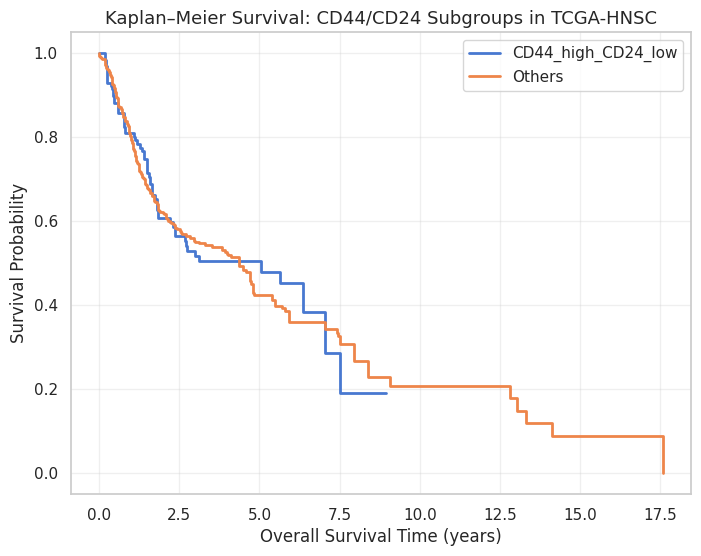

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np

# Merge biomarkers with survival data
merged_df = pd.merge(
    biomarkers, surv_df, left_index=True, right_on='sample', how='inner'
)
print("Merged data:", merged_df.shape)

# Define groups based on CD44/CD24 expression medians
cd44_median = merged_df['CD44'].median()
cd24_median = merged_df['CD24'].median()

merged_df['group'] = np.where(
    (merged_df['CD44'] > cd44_median) & (merged_df['CD24'] < cd24_median),
    'CD44_high_CD24_low', 'Others'
)

# Kaplan–Meier fitting
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for label, df_group in merged_df.groupby('group'):
    kmf.fit(df_group['OS.time']/365, event_observed=df_group['OS'], label=label)
    kmf.plot_survival_function(ci_show=False, lw=2)

plt.title("Kaplan–Meier Survival: CD44/CD24 Subgroups in TCGA-HNSC", fontsize=13)
plt.xlabel("Overall Survival Time (years)")
plt.ylabel("Survival Probability")
plt.grid(alpha=0.3)

# Log-rank test
group1 = merged_df.query("group=='CD44_high_CD24_low'")
group2 = merged_df.query("group=='Others'")
result = logrank_test(group1['OS.time'], group2['OS.time'],
                      event_observed_A=group1['OS'],
                      event_observed_B=group2['OS'])
print(f"Log-rank p-value: {result.p_value:.4f}")
plt.show()
